<a href="https://colab.research.google.com/github/jomacuesta/Machine-Learning/blob/main/Deep_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cabecera del proyecto**


**04-21 Máster U. en Big Data y Ciencia de Datos**

**12 MBID REDES NEURONALES Y DEEP LEARNING**

**Alumnos:** Jose Manuel Cuesta y Albert de Marco

**Actividad:** Proyecto de Programación: "Deep Vision in classification tasks"

# **0. Preparación del entorno de trabajo** 

En este paso, realizaremos la conexión con Google Drive y crearemos un directorio (BASE FOLDER) para trabajar de forma conjunta.

In [ ]:
 # Conectamos con nuestro Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Se establece una ruta absoluta a un directorio existente de Google Drive
BASE_FOLDER = "/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/"

In [ ]:
# Se crea un directorio como Base para el proyecto
!mkdir "/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/"

mkdir: cannot create directory ‘/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/’: File exists


# **1. Proceso de carga de datos** (desde la plataforma de Kaggle)

Este bloque solo será necesario ejecutarlo una vez, ya que tras ésta, habremos cargado los datos a nuestro Base Folder.


## 1.1 Conexión Kaggle

In [ ]:
%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files

In [ ]:
import os 
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Se asegura el tener la ultima version de la API de Kaggle en Collab
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a316fafdc0189c4ceb5e9719913a48f10d256ad1b3b33aa3ac9fcbfbc4b5bace
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


## 1.2 Carga de datos

Este paso es el responsable de la descarga de datos en Kaggle depositándolos en nuestro Drive, en concreto, dentro de Base Folder en una carpeta denominada our_dataset.

In [ ]:
# Se listan los datasets disponibles en kaggle para su descarga
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18193       1411  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10886        770  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5478        355  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [ ]:
# una vez aceptadas las "Competition Rules"
# se procede a descargar el DataSet asignado "Clasificacion de semillas de plantas"
!kaggle competitions download -c plant-seedlings-classification

 99% 1.68G/1.69G [00:19<00:00, 104MB/s]
100% 1.69G/1.69G [00:19<00:00, 91.9MB/s]


In [ ]:
#Nos movemos a la carpeta creada para el desarrollo del proyecto.
%cd "/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/"

/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco


In [ ]:
# Se crea un directorio para descomprimir los datos
!mkdir our_dataset

In [ ]:
# Se descomprimen los datos y se dejan listos para trabajar
"""
!unzip /content/plant-seedlings-classification.zip -d our_dataset
"""

'\n!unzip /content/plant-seedlings-classification.zip -d our_dataset\n'

## 1.3 División de los datos en Train-Test
Creamos carpeta de Test moviendo imágenes a dicho directorio de forma aleatoria y respetando la arquitectura de carpetas.

In [ ]:
# importacion de librerias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Miramos el numero de archivos descargados
import os
print("Train :", len(os.listdir('our_dataset/train/')))
print("Test :", len(os.listdir('our_dataset/test/')))

Train : 12
Test : 794


En la carpeta "train" disponemos de 12 elementos que se corresponden con el número de carpetas. Estas carpetas indican las clases existentes, entre las que tendremos que clasificar las imágenes, y en su interior se encuentran todas las imágenes que disponemos para el ejercicio.

Por otro lado, la carpeta "test" posee 794 imágenes que pueden ser empleadas para evaluar el modelo en la plataforma de Kaggle, prediciendo la clase a la que pertenecen.

A continuación, analizamos el total de imágenes de la carpeta train que se corresponde con nuestro DataSet.



In [ ]:
def count_images(root_folder):
  imgs = 0
  for folder in os.listdir(root_folder):
    path, dirs, files = next(os.walk(root_folder+folder)) #listdir no recarga y solo toma tamaño de primera vista.(uso walk)
    mensaje = "La clase {} posee {} imágenes".format(folder,len(files))
    print(mensaje)
    imgs += len(files)

  print("\n------ EL TOTAL DE IMÁGENES ES : {} --------".format(imgs))

#Llamamos a la función desarrollada
count_images('our_dataset/train/')

La clase Black-grass posee 263 imágenes
La clase Charlock posee 390 imágenes
La clase Cleavers posee 287 imágenes
La clase Common Chickweed posee 611 imágenes
La clase Common wheat posee 221 imágenes
La clase Fat Hen posee 475 imágenes
La clase Loose Silky-bent posee 654 imágenes
La clase Maize posee 221 imágenes
La clase Scentless Mayweed posee 516 imágenes
La clase Shepherds Purse posee 231 imágenes
La clase Small-flowered Cranesbill posee 496 imágenes
La clase Sugar beet posee 385 imágenes

------ EL TOTAL DE IMÁGENES ES : 4750 --------


Este DataSet será divididio en los siguientes set de datos:

- Set de training  
- Set de validation 
- Set de test 

Para hacer la división realizaremos un 85%-15% de los datos contenidos en la carpeta train generarando training y test. Dentro de ese 85%, destinaremos un 15% para generar el set de validation.

In [ ]:
#Para evitar confusiones, renombramos la carpeta 'test' a carpeta 'submission_images'
os.rename('our_dataset/test/', 'our_dataset/submission_images/')


In [ ]:
#Creamos la carpeta de test
!mkdir "our_dataset/test/"

In [ ]:
#Dividimos los datos en Train y Test con un 85-15%
#La función baraja imágenes y mueve archivos
import random
import shutil
def split_images_train_test(test_size): #test_size entre 0-1

  if len(os.listdir("our_dataset/test/")) == 0: #Es la primera vez que se ejecuta
      print("Ejecutando..")
      for folder in os.listdir("our_dataset/train/"):
        
            dir = "our_dataset/test/" + folder
            os.mkdir(dir) #Creamos la misma carpeta en Test
            imgs = os.listdir("our_dataset/train/" + folder)#Miramos los archivos de esa carpeta en Train
            random.seed(32) #Marcamos semilla para experimento reproducible
            random.shuffle(imgs) #Barajamos los nombres de las imágenes
            num_files_test = int(len(imgs)*test_size) #Calculamos num de imagenes que debemos coger
            imgs = imgs[:num_files_test]
            for img in imgs:
              
              shutil.move("our_dataset/train/" + folder +"/" + img, "our_dataset/test/" + folder +"/" + img) 
  else:
    print("La carpeta Test ya fue creada")
  
  print("-----Split Realizado")

In [ ]:
split_images_train_test(0.15) #Realizo split de 0.15

Ejecutando..
-----Split Realizado


In [ ]:
count_images('our_dataset/train/') #Observamos como cada una de las clases se ha reducido en un 15%

La clase Black-grass posee 224 imágenes
La clase Charlock posee 332 imágenes
La clase Cleavers posee 244 imágenes
La clase Common Chickweed posee 520 imágenes
La clase Common wheat posee 188 imágenes
La clase Fat Hen posee 404 imágenes
La clase Loose Silky-bent posee 556 imágenes
La clase Maize posee 188 imágenes
La clase Scentless Mayweed posee 439 imágenes
La clase Shepherds Purse posee 197 imágenes
La clase Small-flowered Cranesbill posee 422 imágenes
La clase Sugar beet posee 328 imágenes

------ EL TOTAL DE IMÁGENES ES : 4042 --------


# **2 Creación de los conjuntos Train-Validation-Test**


In [ ]:
# importacion de librerias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

os.chdir(BASE_FOLDER)

Para realizar la división en los tres Set mencionados, emplearemos la clase ImageDataGenerator que permite rápidamente crear generadores de python que pueden convertir automáticamente archivos de imágenes en disco en 'batches' de tensores preprocesados.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15) #Guardamos 15% para validation dentro del dataset de training.
test_datagen = ImageDataGenerator(rescale=1./255)

El empleo de este método, hará que durante el aprendizaje no se empleen las imágenes originales, si no los resultados de los objetos ImagaDataGenerator. 

Comenzamos sin aplicar ningún cambio a dichas imágenes, únicamente la normalización del valor de los píxeles de la escala original RGB, a un rango [0-1].

In [ ]:
train_generator = train_datagen.flow_from_directory(
    
                      'our_dataset/train/',
                      target_size=(256, 256),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42,
                      subset='training')

validation_generator = train_datagen.flow_from_directory(
    
                      'our_dataset/train/',
                      target_size=(256, 256),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42,
                      subset='validation')

test_generator = test_datagen.flow_from_directory(
    
                      'our_dataset/test/',
                      target_size=(256, 256),
                      batch_size = 32,
                      seed=42,
                      shuffle = False,
                      class_mode='categorical')
                                                    

Found 3441 images belonging to 12 classes.
Found 601 images belonging to 12 classes.
Found 708 images belonging to 12 classes.


# **3. Inspección del Conjunto de Datos**

En este apartado, se realizarán algunas actividades de inspección como son las siguientes:

- 3.1 Comprobación del tamaño de las imágenes iniciales.
- 3.2 Análisis de los DataSets generados en el apartado anterior.
- 3.3 Muestreo de imágenes de los DataSets.

### 3.1 Comprobación del tamaño de las imágenes iniciales


In [ ]:
#Comprobamos la homogeneidad de las imágenes de entrada en una de las carpetas
from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width,height
contador=0
for img in os.listdir("/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/our_dataset/train/Black-grass/"):
    contador += 1
    if contador < 5:
          print(get_num_pixels("/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/our_dataset/train/Black-grass/" + img))
    else:
      break

(196, 196)
(388, 388)
(886, 886)
(117, 117)


Comprobando únicamente un pequeño grupo, podemos concluir que no poseen un tamaño fijo. Por este motivo se estandarizó los tamaños en el paso de división de los tres conjuntos de estudio (train-validation y test)

### 3.2 Análisis de los DataSets generados en el apartado 1.4

In [ ]:
type_dataset = str(type(train_generator))
print("La tipología de los DataSets generados es : " + type_dataset)

La tipología de los DataSets generados es : <class 'keras.preprocessing.image.DirectoryIterator'>


In [ ]:
#Comparamos el formato obtenido tras las operaciones de preprocesado realizadas al generar los 3 conjuntos típicos del Machine Learning.
#Los 3 conjuntos tendrán el mismo tamaño
for image_batch, labels_batch in train_generator: #Recorremos solo el primer lote para comprobar los tamaños
    print("Las dimensiones asociadas a cada batch de imágenes son : " + str(image_batch.shape)) 
    print("Las dimensiones asociadas a las etiquetas son : " + str(labels_batch.shape))
    break

Las dimensiones asociadas a cada batch de imágenes son : (32, 256, 256, 3)
Las dimensiones asociadas a las etiquetas son : (32, 12)


In [ ]:
image_batch[0] #Observo la primera imagen

array([[[0.2509804 , 0.227451  , 0.18431373],
        [0.34509805, 0.3254902 , 0.27450982],
        [0.34509805, 0.3254902 , 0.28235295],
        ...,
        [0.34117648, 0.2901961 , 0.23529413],
        [0.30980393, 0.2627451 , 0.20392159],
        [0.32156864, 0.2627451 , 0.20784315]],

       [[0.24705884, 0.22352943, 0.19215688],
        [0.27450982, 0.2509804 , 0.20784315],
        [0.32156864, 0.29803923, 0.2627451 ],
        ...,
        [0.3137255 , 0.2509804 , 0.20784315],
        [0.3137255 , 0.2509804 , 0.20784315],
        [0.32156864, 0.2509804 , 0.20784315]],

       [[0.24705884, 0.21960786, 0.19607845],
        [0.2392157 , 0.21176472, 0.1764706 ],
        [0.27058825, 0.2392157 , 0.20784315],
        ...,
        [0.31764707, 0.2627451 , 0.22352943],
        [0.32156864, 0.2627451 , 0.22352943],
        [0.32941177, 0.25882354, 0.22352943]],

       ...,

       [[0.3529412 , 0.31764707, 0.23529413],
        [0.36862746, 0.3372549 , 0.2509804 ],
        [0.36862746, 0

In [ ]:
#Comprobamos que el valor máximo de pixel es 1, utilizando para ello el primer batch de imágenes.
for i in range(32):
    np_image = image_batch[i]
    print("Max valor de pixel en la imagen " + str(i) + " : " + str(np.max(np_image))) #Maximo valor de pixel para cada una de las imágenes del primer batch.

Max valor de pixel en la imagen 0 : 0.6627451
Max valor de pixel en la imagen 1 : 0.7019608
Max valor de pixel en la imagen 2 : 0.54901963
Max valor de pixel en la imagen 3 : 0.6431373
Max valor de pixel en la imagen 4 : 0.6117647
Max valor de pixel en la imagen 5 : 0.77647066
Max valor de pixel en la imagen 6 : 0.7058824
Max valor de pixel en la imagen 7 : 0.6627451
Max valor de pixel en la imagen 8 : 0.86274517
Max valor de pixel en la imagen 9 : 0.8196079
Max valor de pixel en la imagen 10 : 0.59607846
Max valor de pixel en la imagen 11 : 1.0
Max valor de pixel en la imagen 12 : 0.65882355
Max valor de pixel en la imagen 13 : 0.6784314
Max valor de pixel en la imagen 14 : 0.69803923
Max valor de pixel en la imagen 15 : 0.6039216
Max valor de pixel en la imagen 16 : 0.80392164
Max valor de pixel en la imagen 17 : 0.82745105
Max valor de pixel en la imagen 18 : 0.8862746
Max valor de pixel en la imagen 19 : 0.5294118
Max valor de pixel en la imagen 20 : 0.6039216
Max valor de pixel en

In [ ]:
# Comprobamos que los 3 conjuntos poseen todas las clases existentes.
print(set(train_generator.classes))
print(set(validation_generator.classes))
print(set(test_generator.classes))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [ ]:
#Verificamos el orden en el que se toman las clases - Empleamos os.walk ya que Keras indica que es el método empleado
classes = []
for (root,dirs,files) in os.walk("our_dataset/train"):
  classes = dirs
  break
print(dirs)


['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


### 3.3 Muestreo de imágenes de los DataSets

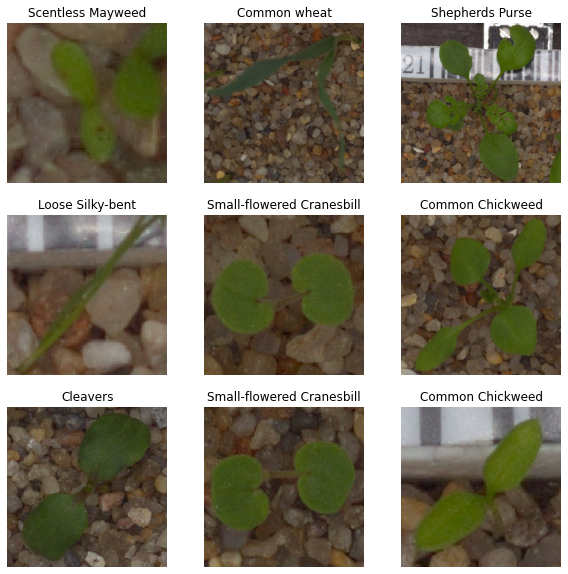

In [ ]:
#Vamos a observar algunas de las imágenes que se encuentran dentro de un batch

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image,label in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    index = np.argmax(label[i])
    plt.title(classes[index])
    plt.axis("off")
  break  

# **4. Acondicionamiento del Conjunto de Datos**

En este apartado, procederemos al tratamiento de las imágenes, y los targets de tal modo que los rangos de valores no condicionen el rendimiento de la red que será elaborada. 

Por tanto, comenzaremos normalizando los valores de los pixeles en un rango de 0-1, teniendo en cuenta que en estos momentos se encuentran en un rango de 0-255 y los targets serán sometidos a one-hot encoding para que las etiquetas no sean texto.

Los puntos contenidos son los siguientes:

- 4.1 Normalización de las imágenes
- 4.2 One-hot Encoding aplicado a labels.
- 4.3 Creación de contenedor DataGenerator para aumento de muestras.

### 4.1 Normalización de las imágenes

Normalizamos los datos de los píxeles a un rango 0-1 en los tres conjuntos de datos. Este proceso, lo realiza el objeto ImageDataGenerator generado previamente.

### 4.2 One-hot Encoding aplicado a labels.

Es importante para poder trabajar con el MLP final pasar los target a valores numéricos. En concreto, utilizaremos "to_categorical" sobre los targets que estarán formados por arrays de una dimensión y 12 elementos, donde todos los valores serán 0, excepto uno, cuya posición indicará la clase a la que pertenece dicha imagen.

### 4.3 Creación de objeto DataGenerator para aumento de muestras

Creamos el objeto destinado a un posible proceso de Data Augmentation, aplicando ahora sí transformaciones de las imágenes originales que puedan evitar overfitting en el modelo.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    vertical_flip=True,
    zoom_range=0.2, # rango de zoom
    shear_range=0.1
)

# **5. Modelos CNN propios**

## Modelo 1.(Sin Data Augmentation)

###Arquitectura del modelo

In [ ]:
# crearemos LA primera topologia CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# sera una feedforward secuencial
RedCNN = Sequential()  # creamos la instancia de la red
TamImagen = (256,256,3) # trabajamos con imagenes 256 x 256 pixeles en color (3 canales)

############################################ BASE_MODEL
### PRIMER SET CONV,RELU,CONV,RELU,POOL
# Iniciamos con una capa convolucional, y un mapa de activación ReLU, que normalmente trabaja bien
# el tamaño de Kernel, utilizamos el (3,3) visto en clase
# tambien decidimos hacer pooling tomando el maximo, y luego en función de los resultados, variaremos para ver la influencia

RedCNN.add(layers.Conv2D(32, (3,3), input_shape = TamImagen, activation='relu',padding='same'))
#RedCNN.add(layers.MaxPooling2D((2,2)))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.Conv2D(32, (3,3), activation='relu',padding='same'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.MaxPooling2D((2,2)))
RedCNN.add(layers.Dropout(0.8))

### SEGUNDO SET CONV,RELU,CONV,RELU,POOL
RedCNN.add(layers.Conv2D(64, (3,3), activation='relu', padding = 'same'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.Conv2D(64, (3,3), activation='relu', padding = 'same'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.MaxPooling2D((2,2)))
RedCNN.add(layers.Dropout(0.8))

### TERCER SET CONV,RELU,CONV,RELU,POOL

RedCNN.add(layers.Conv2D(256, (3,3), activation='relu', padding = 'same'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.Conv2D(256, (3,3), activation='relu', padding = 'same'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.MaxPooling2D((2,2)))
RedCNN.add(layers.Dropout(0.8))

############################################# TOP MODEL
# aplanamos el resultado de las diferentes capas convolucionales
RedCNN.add(layers.Flatten())

# introducimos una nueva capa densa, con el mismo numero de filtro de la ultima capa antes de hacer el aplanado
RedCNN.add(layers.Dense(256, activation='relu'))
RedCNN.add(layers.BatchNormalization())
RedCNN.add(layers.Dropout(0.8))

# y en la ultima capa, la capa de salida, ponemos tantas neuronas como clases de hojas estamos tratando, 12
# con un mapa de activacion 'softmax'
RedCNN.add(layers.Dense(12, activation='softmax'))



In [ ]:
# visualizamos la red creada
RedCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                        

###Compilación y entrenamiento

In [ ]:
# compilamos el modelo
RedCNN.compile(optimizer=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# entrenamos el modelo, primero 5 epocas para ver la velocidad y ver si es asumible el 
# coste computacional y aumentar el numero de epocas
history = RedCNN.fit_generator(train_generator,steps_per_epoch=108,epochs = 20,  validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
108/108 [==============================] - 2012s 19s/step - loss: 3.0256 - accuracy: 0.2046 - val_loss: 5.8250 - val_accuracy: 0.1381
Epoch 2/20
108/108 [==============================] - 71s 658ms/step - loss: 1.8092 - accuracy: 0.4345 - val_loss: 4.1657 - val_accuracy: 0.0998
Epoch 3/20
108/108 [==============================] - 71s 655ms/step - loss: 1.4220 - accuracy: 0.5257 - val_loss: 4.3033 - val_accuracy: 0.1664
Epoch 4/20
108/108 [==============================] - 70s 648ms/step - loss: 1.2052 - accuracy: 0.6022 - val_loss: 4.9273 - val_accuracy: 0.1414
Epoch 5/20
108/108 [==============================] - 70s 642ms/step - loss: 1.0719 - accuracy: 0.6455 - val_loss: 6.3128 - val_accuracy: 0.1381
Epoch 6/20
108/108 [==============================] - 70s 643ms/step - loss: 0.9465 - accuracy: 0.6867 - val_loss: 3.1425 - val_accuracy: 0.2845
Epoch 7/20
108/108 [==============================] - 70s 641ms/step - loss: 0.8537 - accuracy: 0.7167 - val_loss: 1.9507 - val_ac

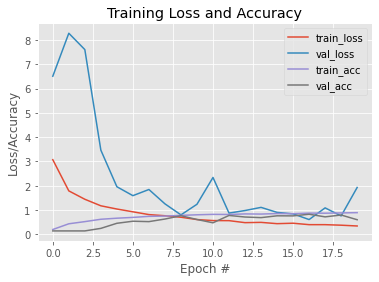

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Práctica de grabado en disco del modelo y recuperación del mismo

In [ ]:
#RedCNN.save('classification_plants.h5') #una vez ejecutado. se comenta para futuras ejecuciones del proyecto para evitar que produzca errores

In [ ]:
RedCNN = tf.keras.models.load_model('classification_plants.h5') 

###Evalución del modelo en Test
Chequeamos su capacidad de generalización

In [ ]:
test_score = RedCNN.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 66.81%
[INFO] Loss:  1.1653081178665161


In [ ]:
predictions = RedCNN.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
# Sacamos el report para test
print(classification_report(test_generator.classes, predictions, target_names=classes))

                           precision    recall  f1-score   support

              Black-grass       0.67      0.05      0.10        39
                 Charlock       1.00      0.52      0.68        58
                 Cleavers       0.93      0.63      0.75        43
         Common Chickweed       0.84      0.79      0.81        91
             Common wheat       0.95      0.55      0.69        33
                  Fat Hen       0.97      0.45      0.62        71
         Loose Silky-bent       0.47      0.97      0.63        98
                    Maize       1.00      0.24      0.39        33
        Scentless Mayweed       0.39      0.94      0.55        77
          Shepherds Purse       0.50      0.21      0.29        34
Small-flowered Cranesbill       0.78      0.93      0.85        74
               Sugar beet       0.89      0.14      0.24        57

                 accuracy                           0.62       708
                macro avg       0.78      0.53      0.55    

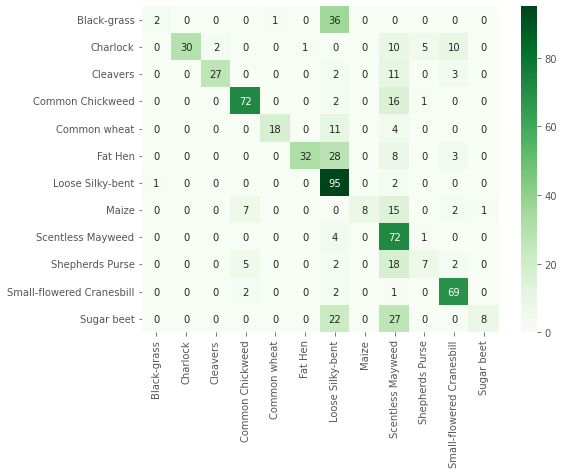

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = [classes[id] for id in test_generator.classes]
y_pred = [classes[id] for id in predictions]
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(cm,  cmap=plt.cm.Greens,annot=True,xticklabels=classes, yticklabels=classes)

Observamos que existen momentos en los que la red obtuvo "buenos" resultados en validation, sin embargo se puede observar la aparición de overfitting durante todo el entrenamiento lo que indicaría que nuestra red no sería estable.

Debido al efecto de overfitting a pesar del uso de BatchNormalization y Dropout con un 80%, procederemos al empleo de DataAugmentation.


## Modelo 2. (Con Data Augmentation)

### Generación de directorios train_aug y val_aug

Para realizar este apartado y evitar que apliquemos data augmentation al conjunto de validación, antes de comenzar, vamos a generar dos directorios a partir de train (train_aug y val_aug), de este modo podremos aplicar tratamientos diferentes a dichas imágenes.


In [ ]:
#Creamos los directorios
!mkdir "our_dataset/train_aug/"
!mkdir "our_dataset/val_aug/"

In [ ]:
#Dividimos los datos en Train y Validation con un 85-15%
#La función baraja imágenes y copia archivos (No queremos eliminar la división anterior de Train y Test realizada en el apartado 1)
import random
import shutil
def split_images_train_validation(validation_size): #validation_size entre 0-1

  if len(os.listdir("our_dataset/train_aug/")) == 0: #Es la primera vez que se ejecuta
      print("Ejecutando..")
      for folder in os.listdir("our_dataset/train/"):
        
            dir1 = "our_dataset/train_aug/" + folder
            dir2 = "our_dataset/val_aug/" + folder
            os.mkdir(dir1) 
            os.mkdir(dir2) 
            imgs = os.listdir("our_dataset/train/" + folder)#Miramos los archivos de esa carpeta en Train
            random.seed(32) #Marcamos semilla para experimento reproducible
            random.shuffle(imgs) #Barajamos los nombres de las imágenes
            num_files_test = int(len(imgs)*validation_size) #Calculamos num de imagenes que debemos coger
            imgs_val = imgs[:num_files_test]
            imgs_train = imgs[num_files_test:]#revisar esto con ejemplo
            for img in imgs_val:
              
              shutil.copyfile("our_dataset/train/" + folder +"/" + img, "our_dataset/val_aug/" + folder +"/" + img) 

            for img in imgs_train:
              
              shutil.copyfile("our_dataset/train/" + folder +"/" + img, "our_dataset/train_aug/" + folder +"/" + img)
  else:
    print("Las carpetas train_aug y val_aug ya fueron creadas")
  
  print("-----Split Realizado")

In [ ]:
split_images_train_validation(0.15)

Las carpetas train_aug y val_aug ya fueron creadas
-----Split Realizado


### Comprobación del generador de imágenes

En este apartado, verificamos que las transformaciones realizadas no deforman la imagen original.

In [ ]:
path_black_grass = "/content/drive/MyDrive/12MBID_Proyecto_JM_Cuesta_A_de_Marco/our_dataset/train/Black-grass/"

In [ ]:
#En primer lugar comprobamos el funcionamiento del objeto generado anteriormente
from keras.preprocessing import image
import os
fnames = [os.path.join(path_black_grass,fname) for fname in os.listdir(path_black_grass)]

In [ ]:
def apply_DA_image(num):#num es un valor para elegir la imagen que se someterá a Data Augmentation

  img_path = fnames[num]
  img = image.load_img(img_path,target_size=(256,256))
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape) #Reescala a (1,256,256,3)
  i = 0
  for batch in datagen_aug.flow(x,batch_size=1):
      plt.figure(i)
      imgplot = plt.imshow(image.array_to_img(batch[0]))
      i += 1
      if i%4 ==0:
        break
  plt.show()


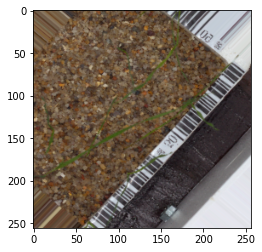

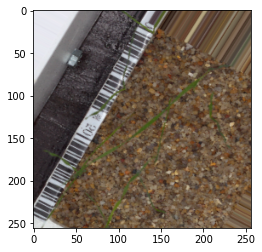

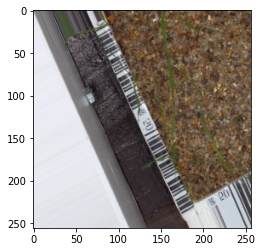

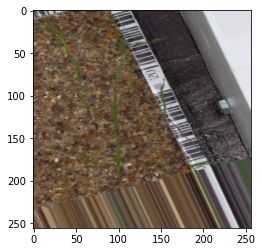

In [ ]:
apply_DA_image(8) #Tomo una imagen cualquiera

### Creación de los generadores de datos (Train-Validation-Test)

In [ ]:
train_generator = datagen_aug.flow_from_directory(
    
                      'our_dataset/train_aug/',
                      target_size=(180, 180),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42)

validation_generator = test_datagen.flow_from_directory( #Empleamos generador de test para solo realizar escalado
    
                      'our_dataset/val_aug/',
                      target_size=(180, 180),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42)

test_generator = test_datagen.flow_from_directory( 
    
                      'our_dataset/test/',
                      target_size=(180, 180),
                      batch_size = 32,
                      seed=42,
                      shuffle = False,
                      class_mode='categorical')

Found 3441 images belonging to 12 classes.
Found 601 images belonging to 12 classes.
Found 708 images belonging to 12 classes.


### Arquitectura del modelo

Para la siguiente arquitectura, y con objetivo de reducir el overfitting que por ende se traducirá en un modelo con mayor capacidad de generalización se han tenido en cuenta los siguientes conceptos: 

- Reducción de la capacidad de memorización del modelo: Para ello, se reduce el número de parámetros entrenables reduciendo la cantidad de capas convolucionales y el aumento de maxpooling.

- Aumento de muestras: Se emplea data augmentation para modificar las imágenes de una época a otra.

- Aplicación de regularización L2: Forzando a tener valores pequeños los pesos, que eviten memorizar datos que puedan clasificar erróneamente.

- Mantenemos el batch ya que aunque la precisión no era demasiado buena, pero la perdida en validación iba mejorando, queremos evitar que funcione la precisión a base de clasificar en las clases más abundantes.

In [ ]:
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# sera una feedforward secuencial
model_aug = Sequential()  # creamos la instancia de la red
TamImagen = (180,180,3) # trabajamos con imagenes de este tamaño en pixeles y en color (3 canales)

############################################ BASE_MODEL

#Primer bloque
model_aug.add(layers.Conv2D(16, (3,3), input_shape = TamImagen, activation='relu',padding='same'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.Dropout(0.2))

#Segundo bloque
model_aug.add(layers.Conv2D(32, (3,3), activation='relu',padding='same'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2,2)))
model_aug.add(layers.Dropout(0.2))

#Tercer bloque
model_aug.add(layers.Conv2D(64, (3,3), activation='relu',padding='same'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2,2)))
model_aug.add(layers.Dropout(0.2))

#Cuarto bloque
model_aug.add(layers.Conv2D(128, (3,3), activation='relu',padding='same'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2,2)))
model_aug.add(layers.Dropout(0.2))

#Quinto bloque
model_aug.add(layers.Conv2D(256, (3,3), activation='relu',padding='same'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2,2)))
model_aug.add(layers.Dropout(0.2))

############################################# TOP MODEL
# aplanamos el resultado de las diferentes capas convolucionales
model_aug.add(layers.Flatten())

# introducimos una nueva capa densa, con el mismo numero de filtro de la ultima capa antes de hacer el aplanado
model_aug.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.Dropout(0.2))

# y en la ultima capa, la capa de salida, ponemos tantas neuronas como clases de hojas estamos tratando, 12
# con un mapa de activacion 'softmax'
model_aug.add(layers.Dense(12, activation='softmax'))

In [ ]:
model_aug.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_24 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 180, 180, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 batch_normalization_25 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 32)      

###Compilación y entrenamiento

In [ ]:
model_aug.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print("[INFO]: Entrenando la red...")
train_size = 3441 #Indicado al crear el generador
batch_size = 32 #Indicado al crear el generador
steps = train_size//batch_size #num entero
H_aug = model_aug.fit(train_generator,validation_data = validation_generator,steps_per_epoch = steps*2, epochs = 30, workers = 4)

[INFO]: Entrenando la red...
Epoch 1/30
214/214 [==============================] - 294s 1s/step - loss: 34.9764 - accuracy: 0.3965 - val_loss: 20.8198 - val_accuracy: 0.1381
Epoch 2/30
214/214 [==============================] - 123s 570ms/step - loss: 17.5520 - accuracy: 0.5440 - val_loss: 19.1518 - val_accuracy: 0.2180
Epoch 3/30
214/214 [==============================] - 125s 572ms/step - loss: 16.3169 - accuracy: 0.5972 - val_loss: 18.9192 - val_accuracy: 0.2280
Epoch 4/30
214/214 [==============================] - 124s 573ms/step - loss: 15.6611 - accuracy: 0.6335 - val_loss: 23.6860 - val_accuracy: 0.1082
Epoch 5/30
214/214 [==============================] - 124s 570ms/step - loss: 13.0388 - accuracy: 0.6716 - val_loss: 12.7576 - val_accuracy: 0.6489
Epoch 6/30
214/214 [==============================] - 122s 560ms/step - loss: 11.5038 - accuracy: 0.6983 - val_loss: 11.6459 - val_accuracy: 0.6339
Epoch 7/30
214/214 [==============================] - 122s 566ms/step - loss: 10.5556 

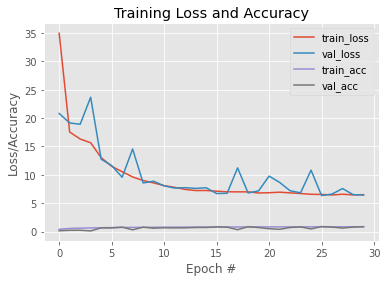

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_aug.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_aug.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H_aug.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_aug.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Evaluación del modelo en test

In [ ]:
test_score = model_aug.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 85.59%
[INFO] Loss:  6.43681526184082


In [ ]:
#Verificamos el orden en el que se toman las clases - Empleamos os.walk ya que Keras indica que es el método empleado
classes = []
for (root,dirs,files) in os.walk("our_dataset/train"):
  classes = dirs
  break
print(dirs)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
#Calculamos predicciones en probabilidad, por el uso de softmax  y tomamos el mayor índice para tomar el elegido.
predictions = model_aug.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=1)
# Sacamos el report para test
print(classification_report(test_generator.classes, predictions, target_names=classes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


                           precision    recall  f1-score   support

              Black-grass       0.76      0.33      0.46        39
                 Charlock       0.83      0.95      0.89        58
                 Cleavers       1.00      0.72      0.84        43
         Common Chickweed       0.90      0.97      0.93        91
             Common wheat       0.88      0.70      0.78        33
                  Fat Hen       0.80      0.96      0.87        71
         Loose Silky-bent       0.74      0.98      0.85        98
                    Maize       0.92      1.00      0.96        33
        Scentless Mayweed       0.87      0.92      0.89        77
          Shepherds Purse       0.81      0.38      0.52        34
Small-flowered Cranesbill       0.94      1.00      0.97        74
               Sugar beet       0.95      0.72      0.82        57

                 accuracy                           0.86       708
                macro avg       0.87      0.80      0.81    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


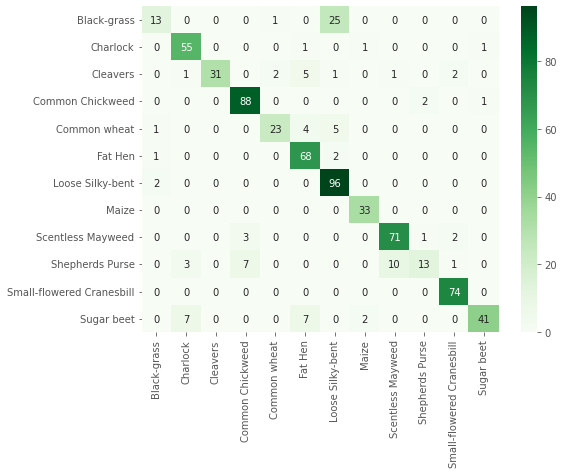

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions = model_aug.predict_generator(test_generator)
predictions = np.argmax(predictions, axis=1)
y_true = [classes[id] for id in test_generator.classes]
y_pred = [classes[id] for id in predictions]
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(cm,  cmap=plt.cm.Greens,annot=True,xticklabels=classes, yticklabels=classes)

# **6. Estrategia 2. Arquitectura con Redes Preentrenadas**

Según las instrucciones del proyecto, procederemos a utilizar dos redes preentrenadas con el Dataset ImageNet. Hemos seleccionado InceptionResNetV2 y Xception, ya que como se ha explicado en clase ofrecen buenos resultados de precisión sin ser demasiado pesadas como los son por ejemplo las VGG. 

Estas dos redes preentrenadas hemos visto que han sido utilizados con bastante éxito en la competición de Kaggle (valores superiores al 97% en ambos casos), por lo que creemos son indicadas para la ejecución del proyecto.

### 6.1 InceptionResNetV2
https://keras.io/api/applications/inceptionresnetv2/

#### Generamos los datos de entrada según el preprocesado específico

Vamos a crear nuevos generadores que permitan aplicar data augmentation únicamente en el conjunto de train, y que además, no reescalen los datos ya que ahora según ResNet, necesitamos que los valores estén entre -1 y 1 , y no entre 0 y 1 como anteriormente los teníamos

In [ ]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_aug = ImageDataGenerator(
    rotation_range=360, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    vertical_flip=True,
    zoom_range=0.2, # rango de zoom
    shear_range=0.1,
    preprocessing_function = preprocess_input
)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
train_generator = datagen_aug.flow_from_directory(
    
                      'our_dataset/train_aug/',
                      target_size=(150, 150),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42)

validation_generator = test_datagen.flow_from_directory( #Empleamos generador de test para solo realizar escalado
    
                      'our_dataset/val_aug/',
                      target_size=(150, 150),
                      batch_size = 32,
                      class_mode='categorical',
                      seed=42)

test_generator = test_datagen.flow_from_directory( 
    
                      'our_dataset/test/',
                      target_size=(150, 150),
                      batch_size = 32,
                      seed=42,
                      shuffle = False,
                      class_mode='categorical')

Found 3441 images belonging to 12 classes.
Found 601 images belonging to 12 classes.
Found 708 images belonging to 12 classes.


#### Creación del modelo ResNet

Importamos el módulo de preprocesado adecuado.

In [ ]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import warnings
from keras.callbacks import ModelCheckpoint
warnings.filterwarnings("ignore")

In [ ]:
##############################################BASE MODEL
#El tamaño minimo es 150 y usaremos éste, para mayor velocidad de entrenamiento y porque además tenemos imágenes que se distorsionarian a 299
model_ResNet_Input = tf.keras.layers.Input(shape=(150, 150, 3), name='image_input')
model_ResNet_Base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',pooling='max')(model_ResNet_Input)

###############################################TOP MODEL

dense = Flatten()(model_ResNet_Base)
dense = Dense(128, activation='relu')(dense)
dense_Drop  = Dropout(0.3)(dense)
model_ResNet_Output = Dense(12, activation="softmax")(dense_Drop)

###############################################CREACION DEL MODELO CON API FUNCIONAL
modelResNet = Model(model_ResNet_Input,  model_ResNet_Output)

In [ ]:
modelResNet.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 1536)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               196736    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 12)                1548      
                                                          

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
modelResNet.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
save_callback = ModelCheckpoint('bestmodel2.h5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
H = modelResNet.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=train_generator.samples // 32,
    validation_data= validation_generator,
    callbacks=[save_callback] 
)

Epoch 1/25
107/107 [==============================] - 141s 1s/step - loss: 2.0910 - accuracy: 0.3502 - val_loss: 1.3287 - val_accuracy: 0.5923
Epoch 2/25
107/107 [==============================] - 118s 1s/step - loss: 1.0828 - accuracy: 0.6366 - val_loss: 0.7126 - val_accuracy: 0.7654
Epoch 3/25
107/107 [==============================] - 119s 1s/step - loss: 0.6665 - accuracy: 0.7735 - val_loss: 0.4891 - val_accuracy: 0.8286
Epoch 4/25
107/107 [==============================] - 118s 1s/step - loss: 0.4931 - accuracy: 0.8328 - val_loss: 0.3808 - val_accuracy: 0.8536
Epoch 5/25
107/107 [==============================] - 119s 1s/step - loss: 0.4274 - accuracy: 0.8530 - val_loss: 0.2857 - val_accuracy: 0.8852
Epoch 6/25
107/107 [==============================] - 108s 1s/step - loss: 0.3446 - accuracy: 0.8771 - val_loss: 0.6199 - val_accuracy: 0.9002
Epoch 7/25
107/107 [==============================] - 117s 1s/step - loss: 0.2983 - accuracy: 0.8929 - val_loss: 0.2342 - val_accuracy: 0.9235

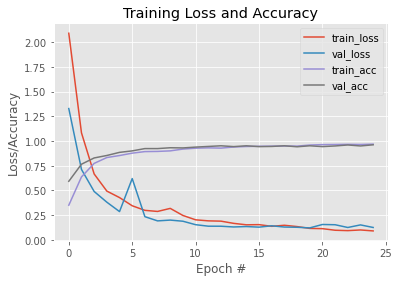

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 25), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
modelResNet.save('ResNet_classification_plants96.h5')

#### Evaluación en Test

In [ ]:
test_score = modelResNet.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 96.19%
[INFO] Loss:  0.11840110272169113


In [ ]:
# Evaluación del modelo
from sklearn.metrics import classification_report
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = modelResNet.predict(test_generator, batch_size=32)
predictions = np.argmax(predictions, axis=1)
# se recogen los diferentes tipos de plantas
classes = []
for (root,dirs,files) in os.walk("our_dataset/train"):
  classes = dirs
  break

# Sacamos el report para test
print(classification_report(test_generator.classes, predictions, target_names=classes))

[INFO]: Evaluando el modelo...
                           precision    recall  f1-score   support

              Black-grass       0.82      0.69      0.75        39
                 Charlock       0.98      1.00      0.99        58
                 Cleavers       1.00      0.98      0.99        43
         Common Chickweed       1.00      0.99      0.99        91
             Common wheat       0.97      0.94      0.95        33
                  Fat Hen       0.99      0.99      0.99        71
         Loose Silky-bent       0.92      0.96      0.94        98
                    Maize       0.97      1.00      0.99        33
        Scentless Mayweed       0.97      0.95      0.96        77
          Shepherds Purse       0.89      0.94      0.91        34
Small-flowered Cranesbill       0.96      1.00      0.98        74
               Sugar beet       1.00      1.00      1.00        57

                 accuracy                           0.96       708
                macro avg    

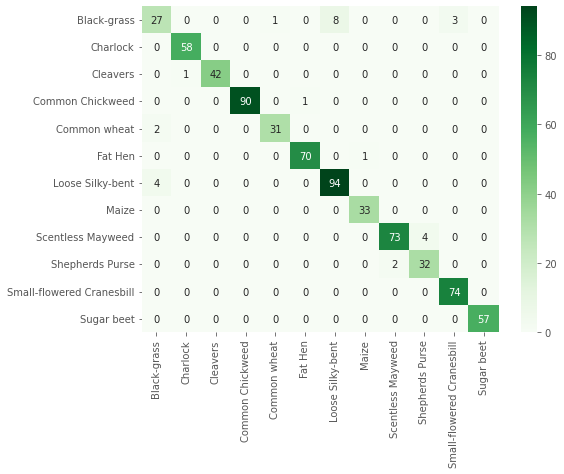

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = [classes[id] for id in test_generator.classes]
y_pred = [classes[id] for id in predictions]
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(cm,  cmap=plt.cm.Greens,annot=True,xticklabels=classes, yticklabels=classes)

###6.2 Xception 
Información relativa a la red preentrenada:

https://keras.io/api/applications/xception/


Consultada la ayuda de Keras, se nos indica que debemos utilizar un modulo de preprocesado a las entrada, llamando al modulo **tf.keras.applications.xception.preprocess_input** antes de pasarlas al modelo. Esta función escalará los pixels de entrada entre -1 y 1

Configuración de los parámetros de la red preentrenada
- include_top = False --> al haber estado entrenado en multitud de tipologías de imágenes, no nos quedaremos con las capas más densas, más especializadas, sino que las entrenaremos ad-hoc
- weights = "imagenet" --> utilizaremos el conocimiento (objetivo de usar una red preentrenada)
- input_shape: Debe tener obligatoriamente 3 canales de entrada, y la altura y anchura no debe ser menor que 71
- pooling: admite 3 valores posibles si no importamos el top model (Como es el caso)
  - None: la salida del modelo será el tensor 4D de salida del último bloque convolucional
  - avg: se aplicará pooling promedio a la salida del último bloque convolucional. Así la salida del modelo será un tensor 2D
  - max: se aplicará pooling máximo


####6.2.1 Cargamos la topología de la red entrenada Xception

In [ ]:
# importamos de la base de datos de Keras la red Exception
from tensorflow.keras.applications import Xception
base_model_02 = Xception (include_top = False, #no interesa incluir la parte más densa ya que nos interesa entrenarla de manera específica
                          weights = "imagenet",
                          input_shape =(126, 126, 3),
                          pooling = "max")
base_model_02.summary() #permite visualizar la correcta carga del modelo

83697664/83683744 [==============================] - 2s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 126, 126, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 62, 62, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 62, 62, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

####6.2.2 Se crea el top model

In [ ]:
# partiendo del base model se conectará a la parte densa específica para el proyecto en cuestión
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# la idea de utilizar una red preentrenada es aprovechar su conocimiento, por lo que no la entrenaremos, mantendremos sus pesos originales (Conocimiento)
base_model_02.trainable = False #con esto los pesos no se alteran en la parte convolucional -> Transfer Learning

#al modelo base, le añadiremos simplemente un aplanado, una función de activación ReLU, y una última softmwax con el mismo de neuronas de salida que númnero de clasificaciones tenemos (12)
pre_trained_model_02 = Sequential()
pre_trained_model_02.add(base_model_02) #partimos del modelo base de Xception
pre_trained_model_02.add(layers.Flatten()) # se aplana
pre_trained_model_02.add(layers.Dense(256, activation = "relu"))
pre_trained_model_02.add(layers.Dense(12, activation = "softmax"))

#visualizamos como queda el modelo, y chequeamos que los parametros originales han quedado como no entrenables (mantener conocimiento)
pre_trained_model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21,389,108
Trainable params: 527,628
Non-trainable params: 20,861,480
_________________________________________________________________


####6.2.3 Entrenamos la solucion partiendo de Xception

In [ ]:
# importamos los paquetes necesarios
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

# se recogen los diferentes tipos de plantas
classes = []
for (root,dirs,files) in os.walk("our_dataset/train"):
  classes = dirs
  break

# Compilamos el modelo
pre_trained_model_02.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0005,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) #mismos parametros que vistos en clase

# Entrenamiento de la red
num_epochs = 20
red_pre_02 = pre_trained_model_02.fit(train_generator ,validation_data = validation_generator, batch_size=128, epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
108/108 [==============================] - 88s 782ms/step - loss: 0.8210 - accuracy: 0.7114 - val_loss: 0.7355 - val_accuracy: 0.7321
Epoch 2/20
108/108 [==============================] - 84s 781ms/step - loss: 0.8008 - accuracy: 0.7236 - val_loss: 0.7186 - val_accuracy: 0.7438
Epoch 3/20
108/108 [==============================] - 84s 782ms/step - loss: 0.7726 - accuracy: 0.7294 - val_loss: 0.7399 - val_accuracy: 0.7255
Epoch 4/20
108/108 [==============================] - 84s 779ms/step - loss: 0.7652 - accuracy: 0.7280 - val_loss: 0.7024 - val_accuracy: 0.7521
Epoch 5/20
108/108 [==============================] - 83s 768ms/step - loss: 0.7652 - accuracy: 0.7257 - val_loss: 0.7101 - val_accuracy: 0.7454
Epoch 6/20
108/108 [==============================] - 83s 770ms/step - loss: 0.7705 - accuracy: 0.7297 - val_loss: 0.7531 - val_accuracy: 0.7171
Epoch 7/20
108/108 [==============================] - 83s 768ms/step - loss: 0.7532 - accuracy: 0.7384 - val_loss: 0.7166 - val_ac

In [ ]:
# Almacenamos el modelo empleando la función model.save de Keras
pre_trained_model_02.save(BASE_FOLDER+"JM_AdM_Xception.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model_02.predict(test_generator, batch_size=128)
predictions = np.argmax(predictions, axis=1)

[INFO]: Evaluando el modelo...


In [ ]:
# se recogen los diferentes tipos de plantas
classes = []
for (root,dirs,files) in os.walk("our_dataset/train"):
  classes = dirs
  break

# Sacamos el report para test
print(classification_report(test_generator.classes, predictions, target_names=classes))

                           precision    recall  f1-score   support

              Black-grass       0.65      0.33      0.44        39
                 Charlock       0.93      0.86      0.89        58
                 Cleavers       0.82      0.77      0.80        43
         Common Chickweed       0.88      0.71      0.79        91
             Common wheat       0.73      0.58      0.64        33
                  Fat Hen       0.57      0.82      0.67        71
         Loose Silky-bent       0.69      0.84      0.76        98
                    Maize       0.94      0.88      0.91        33
        Scentless Mayweed       0.70      0.71      0.71        77
          Shepherds Purse       0.44      0.41      0.42        34
Small-flowered Cranesbill       0.86      0.84      0.85        74
               Sugar beet       0.81      0.84      0.83        57

                 accuracy                           0.75       708
                macro avg       0.75      0.72      0.72    

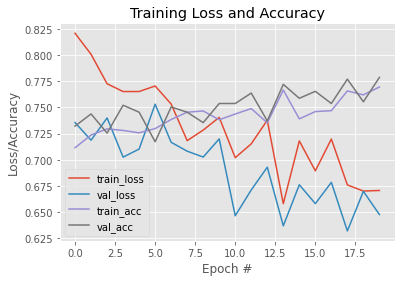

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), red_pre_02.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), red_pre_02.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), red_pre_02.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), red_pre_02.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluacion del modelo en test
test_score = pre_trained_model_02.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[INFO] accuracy: 74.58%
[INFO] Loss:  0.6707558631896973


####6.2.4 "Descongelacion" del ultimo bloque del modelo base. Pasa a Entrenable

In [ ]:
#con objeto de mejorar la precisión, miramos de entrenar alguna capa del modelo base... "descongelamos el último bloque"
# consultando base_model_02.summary(), vemos que la primera capa del último bloque (el 14) es "block14_sepconv1"

base_model_02.trainable = True # hacemos que todos sean entrenables como en origen, y los iremos congelando hasta llegar al bloque que nos interesa
for layer in base_model_02.layers: 
  if layer.name == 'block14_sepconv1': 
    break 
  layer.trainable = False #congelamos, no recalcularemos los pesos

#al modelo descongelado parcialmente, le añadimos la parte ad-hoc igual que antes para ver el efecto de modificar los pesos del ultimo bloque convolutivo
pre_trained_model_02 = Sequential()
pre_trained_model_02.add(base_model_02) #partimos del modelo base de Xception con el ultimo bloque entrenable
pre_trained_model_02.add(layers.Flatten()) # se aplana
pre_trained_model_02.add(layers.Dense(256, activation = "relu"))
pre_trained_model_02.add(layers.Dense(12, activation = "softmax"))

#visualizamos como queda el modelo, y chequeamos que ha aumentado el numero de parametros entrenables en relación al modelo anteriormente probado 
# antes
# Total params: 21,389,108
# Trainable params: 527,628
# Non-trainable params: 20,861,480
pre_trained_model_02.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21,389,108
Trainable params: 5,276,428
Non-trainable params: 16,112,680
_________________________________________________________________


vemos que los parametros entrenables han pasado de poco mas de 500 k a más de 5 MiO tras la descongelación del último bloque

In [ ]:
# Compilamos el modelo
pre_trained_model_02.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0005,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) #mismos parametros que vistos en clase

# Entrenamiento de la red
num_epocas = 20
red_pre_02 = pre_trained_model_02.fit(train_generator ,validation_data = validation_generator, batch_size=128, epochs=num_epocas)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
108/108 [==============================] - 89s 790ms/step - loss: 1.3324 - accuracy: 0.5600 - val_loss: 0.8006 - val_accuracy: 0.7238
Epoch 2/20
108/108 [==============================] - 84s 774ms/step - loss: 0.7079 - accuracy: 0.7448 - val_loss: 0.7304 - val_accuracy: 0.7354
Epoch 3/20
108/108 [==============================] - 93s 859ms/step - loss: 0.6117 - accuracy: 0.7800 - val_loss: 0.7481 - val_accuracy: 0.7654
Epoch 4/20
108/108 [==============================] - 84s 773ms/step - loss: 0.5401 - accuracy: 0.8085 - val_loss: 0.6226 - val_accuracy: 0.7654
Epoch 5/20
108/108 [==============================] - 97s 897ms/step - loss: 0.4782 - accuracy: 0.8352 - val_loss: 0.7093 - val_accuracy: 0.7571
Epoch 6/20
108/108 [==============================] - 83s 771ms/step - loss: 0.4654 - accuracy: 0.8268 - val_loss: 0.6682 - val_accuracy: 0.7654
Epoch 7/20
108/108 [==============================] - 83s 773ms/step - loss: 0.4535 - accuracy: 0.8323 - val_loss: 0.5141 - val_ac

In [ ]:
# Almacenamos el modelo empleando la función model.save de Keras
pre_trained_model_02.save(BASE_FOLDER+"JM_AdM_Xception_02.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model_02.predict(test_generator, batch_size=128)
predictions_np = np.argmax(predictions, axis=1)

[INFO]: Evaluando el modelo...


In [ ]:
 #Sacamos el report para test
print(classification_report(test_generator.classes, predictions_np, target_names=classes))

                           precision    recall  f1-score   support

              Black-grass       0.52      0.56      0.54        39
                 Charlock       0.98      0.98      0.98        58
                 Cleavers       0.98      0.95      0.96        43
         Common Chickweed       0.76      0.99      0.86        91
             Common wheat       0.96      0.79      0.87        33
                  Fat Hen       0.87      0.94      0.91        71
         Loose Silky-bent       0.79      0.79      0.79        98
                    Maize       0.97      1.00      0.99        33
        Scentless Mayweed       0.88      0.90      0.89        77
          Shepherds Purse       1.00      0.44      0.61        34
Small-flowered Cranesbill       0.98      0.78      0.87        74
               Sugar beet       0.92      0.95      0.93        57

                 accuracy                           0.86       708
                macro avg       0.88      0.84      0.85    

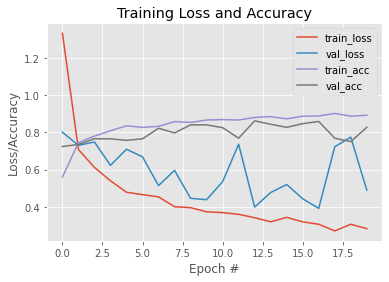

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epocas), red_pre_02.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluacion del modelo en test
test_score = pre_trained_model_02.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[INFO] accuracy: 86.02%
[INFO] Loss:  0.4390101134777069


####6.2.5 "Descongelacion" adicional del penultimo bloque del modelo base. Pasa a Entrenable

In [ ]:
#con objeto de mejorar la precisión, miramos de "descongelar"  un bloque adicional"
# consultando base_model_02.summary(), vemos que la primera capa del bloque anterior (13) al último bloque desgongelado (el 14) es "block13_sepconv1_act"

base_model_02.trainable = True # hacemos que todos sean entrenables como en origen, y los iremos congelando hasta llegar al bloque que nos interesa
for layer in base_model_02.layers: 
  if layer.name == 'block13_sepconv1_act': 
    break 
  layer.trainable = False #congelamos, no recalcularemos los pesos

#al modelo descongelado parcialmente, le añadimos la parte ad-hoc igual que antes para ver el efecto de modificar los pesos del ultimo bloque convolutivo
pre_trained_model_02 = Sequential()
pre_trained_model_02.add(base_model_02) #partimos del modelo base de Xception con el ultimo bloque entrenable
pre_trained_model_02.add(layers.Flatten()) # se aplana
pre_trained_model_02.add(layers.Dense(256, activation = "relu"))
pre_trained_model_02.add(layers.Dense(12, activation = "softmax"))

#visualizamos como queda el modelo, y chequeamos que ha aumentado el numero de parametros entrenables en relación al modelo anteriormente probado 
# antes
# Total params: 21,389,108
# Trainable params: 527,628
# Non-trainable params: 20,861,480
pre_trained_model_02.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21,389,108
Trainable params: 7,316,012
Non-trainable params: 14,073,096
_________________________________________________________________


In [ ]:
# Compilamos el modelo
pre_trained_model_02.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0005,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) #mismos parametros que vistos en clase

# Entrenamiento de la red
num_epocas = 20
red_pre_02 = pre_trained_model_02.fit(train_generator ,validation_data = validation_generator, batch_size=128, epochs=num_epocas)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
108/108 [==============================] - 89s 795ms/step - loss: 0.6961 - accuracy: 0.7663 - val_loss: 0.7462 - val_accuracy: 0.7920
Epoch 2/20
108/108 [==============================] - 84s 782ms/step - loss: 0.4303 - accuracy: 0.8506 - val_loss: 0.3766 - val_accuracy: 0.8552
Epoch 3/20
108/108 [==============================] - 84s 778ms/step - loss: 0.3861 - accuracy: 0.8620 - val_loss: 0.6342 - val_accuracy: 0.7787
Epoch 4/20
108/108 [==============================] - 84s 779ms/step - loss: 0.3207 - accuracy: 0.8878 - val_loss: 0.5722 - val_accuracy: 0.8369
Epoch 5/20
108/108 [==============================] - 84s 779ms/step - loss: 0.3217 - accuracy: 0.8893 - val_loss: 0.4906 - val_accuracy: 0.8170
Epoch 6/20
108/108 [==============================] - 84s 777ms/step - loss: 0.2882 - accuracy: 0.8965 - val_loss: 0.6936 - val_accuracy: 0.8136
Epoch 7/20
108/108 [==============================] - 84s 778ms/step - loss: 0.2823 - accuracy: 0.9009 - val_loss: 0.3954 - val_ac

In [ ]:
# Almacenamos el modelo empleando la función model.save de Keras
pre_trained_model_02.save(BASE_FOLDER+"JM_AdM_Xception_03.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model_02.predict(test_generator, batch_size=128)
predictions_np = np.argmax(predictions, axis=1)

# Sacamos el report para test
print(classification_report(test_generator.classes, predictions_np, target_names=classes))

[INFO]: Evaluando el modelo...
                           precision    recall  f1-score   support

              Black-grass       0.69      0.56      0.62        39
                 Charlock       1.00      0.98      0.99        58
                 Cleavers       0.96      1.00      0.98        43
         Common Chickweed       0.90      0.99      0.94        91
             Common wheat       0.78      0.94      0.85        33
                  Fat Hen       1.00      0.89      0.94        71
         Loose Silky-bent       0.78      0.88      0.83        98
                    Maize       1.00      1.00      1.00        33
        Scentless Mayweed       1.00      0.77      0.87        77
          Shepherds Purse       0.70      0.76      0.73        34
Small-flowered Cranesbill       0.97      0.99      0.98        74
               Sugar beet       0.98      0.98      0.98        57

                 accuracy                           0.90       708
                macro avg    

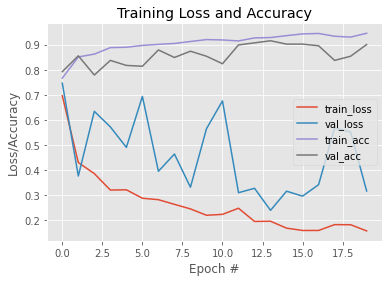

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epocas), red_pre_02.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epocas), red_pre_02.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluacion del modelo en test
test_score = pre_trained_model_02.evaluate_generator(test_generator, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[INFO] accuracy: 90.25%
[INFO] Loss:  0.25776660442352295


MATRIZ DE CONFUSIÓN DE LA SOLUCIÓN ESCOGIDA

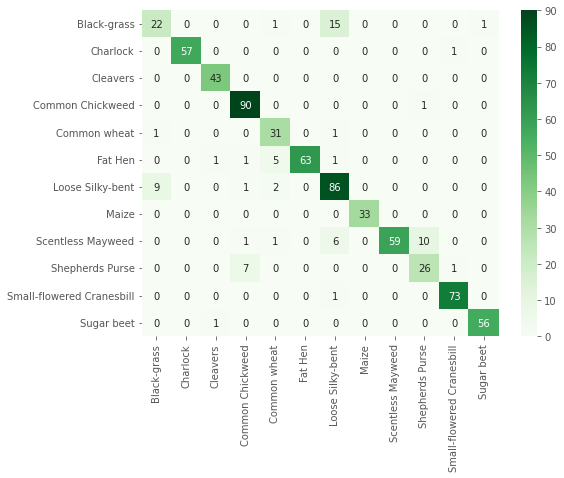

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = [classes[id] for id in test_generator.classes]
y_pred = [classes[id] for id in predictions_np]
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(cm,  cmap=plt.cm.Greens,annot=True,xticklabels=classes, yticklabels=classes)

# **7. Conclusiones**

En base a los resultados obtenidos, optaríamos por utilizar la red generada a partir de la InceptionResNetV2, dado que conseguimos un accuracy de más de un 96% sin muestras de overfitting, contrastado con el conjunto de validation y test, y con el proceso de aprendizaje observado en la curva de train y validation. 

En este enfoque, no se congelaron las capas convolucionales pero conseguimos paliar el overfitting con un entrenamiento corto y "Lento" empleando un learning rate muy bajo, así como con data augmentation. 

Es importante por último, destacar las técnicas empleadas en el proyecto, ya que se empleó Data Augmentation, Dropout, Batch Normalizacion, Weight Regularization,CallBacks, Fine tuning en la segunda red preentrenada para mejorar los resultados obtenidas en la primera ejecución para acercarnos al accuracy de la primera red, así, como diferentes parametrizaciones/configuraciones  de red y funciones de activación.  

Finalmente, probamos el modelo con el conjunto de imágenes de submission en la plataforma de Kaggle obteniendo resultados de 93-94% de accuracy.




# **Generación del pdf** 



In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 85 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/Colab Notebooks/12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb" ./

In [ ]:
!jupyter nbconvert --to PDF "Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb"

[NbConvertApp] Converting notebook Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb to PDF
[NbConvertApp] Support files will be in Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files/
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb to pdf
[NbConvertApp] Support files will be in Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files/
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making directory ./Copia de 12MBID_Proyecto_JM_Cuesta_A_de_Marco_files
[NbConvertApp] Making director

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'

In [ ]:
name_IPYNB_file = '12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb'
get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )
get_ipython().system(
            "jupyter nbconvert 12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb --to pdf"
        )





[NbConvertApp] WARNING | pattern u'12MBID_Proyecto_JM_Cuesta_A_de_Marco.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'no